# Homework 1: Score Matching and Langevin Dynamics

In this section, we will implement Langevin Dynamics on a simple 2D Mixture of Gaussians Model.

It is prohibited to use the library ```torch.distributions``` throughout this homework, as well as any other libraries that do similar calculations such as ```scipy.stats```.

Note that GPUs will not help in any part except the final section with the generation of images (everything else runs in less than a second), so it is recommended to run this part of the homework on a local CPU.

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import random
import matplotlib.pyplot as plt

## Part 1: Computing the density and score of a Gaussian Mixture Model

A Gaussian Mixture Model is a distribution that is the combination of several Gaussian distributions, such as the following:

$$
X | Y \sim \mathcal{N}(\mu_1, \sigma_1 I)Y + \mathcal{N}(\mu_2, \sigma_2 I)(1 - Y)
$$

where $Y \sim \text{Ber}(p)$. In our case, $X \in \mathbb{R}^2$.

Implement the following functions to compute the density and score of a GMM. You can add any other functions required. For score computation, do not use torch's autograd (it will greatly hinder the performance).

In [80]:
mu_1 = torch.tensor([1., 1.])
mu_2 = torch.tensor([-1., -1.])

sigma_1 = torch.sqrt(torch.tensor(0.1))
sigma_2 = torch.sqrt(torch.tensor(0.1))

p_first = torch.tensor(0.15)  # The probability that I will sample from the first distribution.

In [81]:
import math
def density_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p):
    """
    :param X: input data: tensor of shape (N, 2)
    :param mu_1: mean of the first Gaussian
    :param mu_2: mean of the second Gaussian
    :param sigma_1: standard deviation of the first Gaussian
    :param sigma_2: standard deviation of the second Gaussian
    :param p: probability of the first Gaussian
    :return: density of the Gaussian Mixture Model at point X: tensor of shape (N,)
    """
    norm_const1 = 1.0 / (2 * math.pi * sigma_1**2)
    norm_const2 = 1.0 / (2 * math.pi * sigma_2**2)

    dist_sq1 = ((X - mu_1)**2).sum(dim=1)
    dist_sq2 = ((X - mu_2)**2).sum(dim=1)

    #Densities
    densities1 = norm_const1 * torch.exp(-0.5 * dist_sq1 / (sigma_1**2))
    densities2 = norm_const2 * torch.exp(-0.5 * dist_sq2 / (sigma_2**2))

    #The mixture
    total_density = p * densities1 + (1 - p) * densities2

    return densities1, densities2, total_density

In [82]:
def score_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p):
    """
    :param X: input data: tensor of shape (N, 2)
    :param mu_1: mean of the first Gaussian: tensor of shape (2,)
    :param mu_2: mean of the second Gaussian: tensor of shape (2,)
    :param sigma_1: standard deviation of the first Gaussian: tensor of shape (1,)
    :param sigma_2: standard deviation of the second Gaussian: tensor of shape (1,)
    :return: score of the Gaussian Mixture Model at point X: tensor of shape (N, 2)
    """
    f1, f2, f = density_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p)
    
    inv_sigma1_sq = 1.0 / sigma_1**2
    inv_sigma2_sq = 1.0 / sigma_2**2

    num = -p * inv_sigma1_sq * (X - mu_1) * f1.unsqueeze(1) - (1 - p) * inv_sigma2_sq * (X - mu_2) * f2.unsqueeze(1)
    return num / f.unsqueeze(1)

### Visualization

Using a heatmap (with plt.imshow) and an arrow plot (plt.quiver), generate a plot of the density function and score.

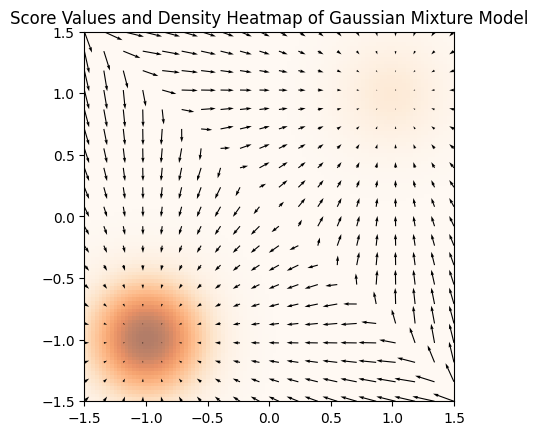

In [83]:
# Steps:
# 1. Create a grid from -1.5 to 1.5 in both dimensions, with 100 points in each dimension (using torch.linspace and torch.meshgrid)
# 2. Compute the density of the Gaussian Mixture Model at each point on the grid and store it in a tensor of shape (100, 100)
# 3. For the quiver plot, create a grid from -1.5 to 1.5 in both dimensions, with 20 points in each dimension
# 4. Compute the score of the Gaussian Mixture Model at each point on the grid and store it in a tensor of shape (20, 20, 2)
# 5. Create a quiver plot with the grid points as the X and Y coordinates and the score as the U and V components
# 6. Create a heatmap of the density, with the grid points as the X and Y coordinates and the density as the color, becoming darker as the density is larger

DENSITY_GRID_SIZE = 100
SCORE_GRID_SIZE = 20

density_grid = torch.zeros(DENSITY_GRID_SIZE, DENSITY_GRID_SIZE)  # Replace this with the relevant matrix, using torch.linspace and torch.meshgrid
score_grid = torch.zeros(SCORE_GRID_SIZE, SCORE_GRID_SIZE, 2)  # Replace this with the relevant matrix, using torch.linspace and torch.meshgrid
density_values = torch.zeros(DENSITY_GRID_SIZE, DENSITY_GRID_SIZE)  # Fill this with the density values
score_values = torch.zeros(SCORE_GRID_SIZE, SCORE_GRID_SIZE, 2)  # Fill this with the score values

#### ADD YOUR CODE HERE ####
x = torch.linspace(-1.5,1.5,DENSITY_GRID_SIZE)
y = torch.linspace(-1.5,1.5,DENSITY_GRID_SIZE)
xx, yy = torch.meshgrid(x,y,indexing = 'ij')
grid_points = torch.stack([xx, yy], dim=-1).reshape(-1, 2) #storing the points

_,_,density = density_gmm(grid_points, mu_1, mu_2, sigma_1, sigma_2, p_first)
density_values = density.reshape(DENSITY_GRID_SIZE,DENSITY_GRID_SIZE)

x_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
y_s = torch.linspace(-1.5, 1.5, SCORE_GRID_SIZE)
xx_s, yy_s = torch.meshgrid(x_s, y_s, indexing='ij')
score_grid = torch.stack([xx_s, yy_s], dim=-1)
score_grid_flat = score_grid.reshape(-1, 2)

score_flat = score_gmm(score_grid_flat, mu_1, mu_2, sigma_1, sigma_2, p_first)
score_values = score_flat.reshape(SCORE_GRID_SIZE, SCORE_GRID_SIZE, 2)

#### DONE WITH SOLUTION ####

plt.imshow(density_values, extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
plt.quiver(score_grid[:, :, 0], score_grid[:, :, 1], score_values[:, :, 0], score_values[:, :, 1], color='black')
plt.title('Score Values and Density Heatmap of Gaussian Mixture Model')
plt.show()

Example output on standard Gaussian:

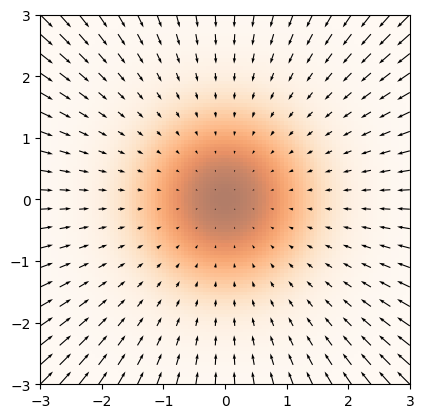

## Part 2: Training a score network

Implement a model that is able to compute the score of a given point sampled from the GMM.

In [84]:
class ScoreMatcher(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,2) #output is in R^2
        )

    def forward(self,X):
        return self.net(X)

In [85]:
def train(mu_1, mu_2, sigma_1, sigma_2, p, train_size, num_epochs, lr):
    """ Return a trained ScoreMatcher model """
    model = ScoreMatcher()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epsilon1 = torch.randn(train_size, 2)
    epsilon2 = torch.randn(train_size, 2)
    samples1 = mu_1 + sigma_1 * epsilon1
    samples2 = mu_2 + sigma_2 * epsilon2

    mask = torch.bernoulli(torch.full((train_size,), p)).unsqueeze(1)
    X = mask * samples1 + (1 - mask) * samples2

    model.train()
    for epoch in range(num_epochs):
        true_scores = score_gmm(X, mu_1, mu_2, sigma_1, sigma_2, p)
        pred_scores = model(X)
        loss = F.mse_loss(pred_scores, true_scores)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model


Print the loss value at each epoch. Make sure the loss is lower than 0.01

In [86]:
model = train(mu_1, mu_2, sigma_1, sigma_2, p_first, 1000, 1000, 0.01)

Epoch 1/1000, Loss: 10.374807
Epoch 11/1000, Loss: 3.561748
Epoch 21/1000, Loss: 0.936355
Epoch 31/1000, Loss: 0.212039
Epoch 41/1000, Loss: 0.052604
Epoch 51/1000, Loss: 0.034031
Epoch 61/1000, Loss: 0.038061
Epoch 71/1000, Loss: 0.101527
Epoch 81/1000, Loss: 0.021977
Epoch 91/1000, Loss: 0.023353
Epoch 101/1000, Loss: 0.008033
Epoch 111/1000, Loss: 0.005882
Epoch 121/1000, Loss: 0.005373
Epoch 131/1000, Loss: 0.004333
Epoch 141/1000, Loss: 0.004806
Epoch 151/1000, Loss: 0.041759
Epoch 161/1000, Loss: 0.026042
Epoch 171/1000, Loss: 0.004515
Epoch 181/1000, Loss: 0.004389
Epoch 191/1000, Loss: 0.003498
Epoch 201/1000, Loss: 0.002692
Epoch 211/1000, Loss: 0.003635
Epoch 221/1000, Loss: 0.224797
Epoch 231/1000, Loss: 0.060462
Epoch 241/1000, Loss: 0.007202
Epoch 251/1000, Loss: 0.007294
Epoch 261/1000, Loss: 0.002605
Epoch 271/1000, Loss: 0.002693
Epoch 281/1000, Loss: 0.001875
Epoch 291/1000, Loss: 0.001406
Epoch 301/1000, Loss: 0.001292
Epoch 311/1000, Loss: 0.001128
Epoch 321/1000, Lo

Create a similar visualization to the visualization you created with the true score, replacing the true score with the model.

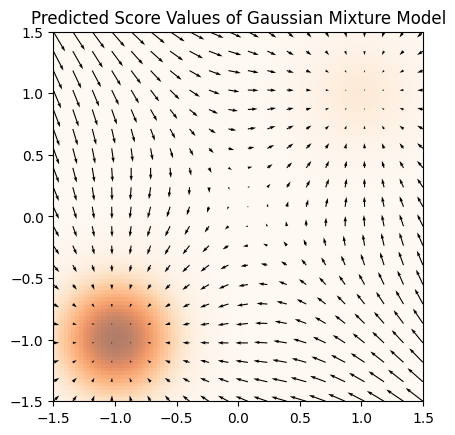

In [87]:
density_grid = None
score_grid = None
density_values = None
score_values = None

#### ADD YOUR CODE HERE ####
x = torch.linspace(-1.5, 1.5, 100)
y = torch.linspace(-1.5, 1.5, 100)
xx, yy = torch.meshgrid(x, y, indexing='ij')
density_grid = torch.stack([xx, yy], dim=-1).reshape(-1, 2)

x_s = torch.linspace(-1.5,1.5,20)
y_s = torch.linspace(-1.5,1.5,20)
xx_s, yy_s = torch.meshgrid(x_s, y_s, indexing='ij')
score_grid = torch.stack([xx_s, yy_s], dim=-1)
flat_points = score_grid.reshape(-1, 2) 
_, _, density_flat = density_gmm(density_grid, mu_1, mu_2, sigma_1, sigma_2, p_first)
density_values = density_flat.reshape(100, 100)

model.eval()
with torch.no_grad():
    pred_scores = model(flat_points)
score_values  = pred_scores.reshape(20, 20, 2)
#### DONE WITH SOLUTION ####

plt.imshow(density_values, extent=(-1.5, 1.5, -1.5, 1.5), origin='lower', cmap='Oranges', alpha=0.6)
plt.quiver(score_grid[:, :, 0], score_grid[:, :, 1], score_values[:, :, 0], score_values[:, :, 1], color='black')
plt.title('Predicted Score Values of Gaussian Mixture Model')
plt.show()

Compare the visualizations and explain what could be causing the differences.

## Part 3: Sampling

In this section we will sample from our distribution using several methods:
1. Directly sampling using torch functions
2. Using Langevin Dynamics using the model that we trained.
3. Using Annealed Langevin Dynamics using the true score function.

Sample 1000 points from the GMM and display them using a scatterplot.

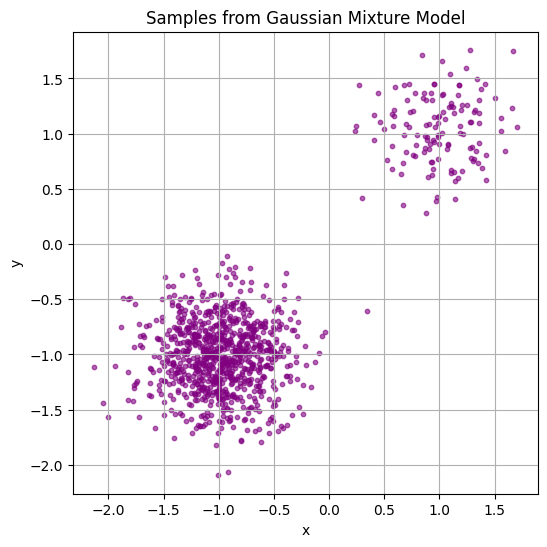

In [88]:
N = 1000

# YOUR CODE HERE

epsilon1 = torch.randn(N, 2)
epsilon2 = torch.randn(N, 2)

samples1 = mu_1 + sigma_1 * epsilon1
samples2 = mu_2 + sigma_2 * epsilon2

mask = torch.bernoulli(torch.full((N,), p_first)).unsqueeze(1)

samples = mask * samples1 + (1 - mask) * samples2

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.6, color='purple')
plt.title("Samples from Gaussian Mixture Model")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()


Sample 1000 points using the score model (Langevin Dynamics).

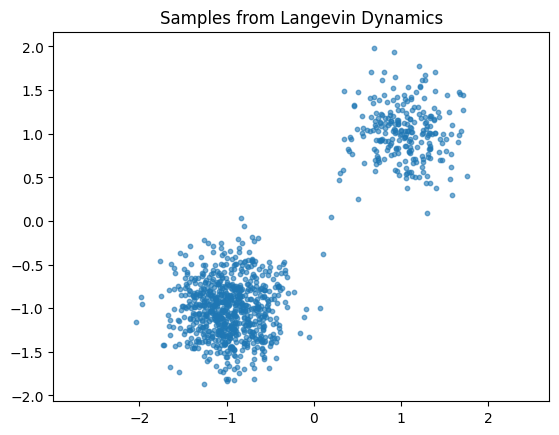

In [89]:
LANGEVIN_STEP_SIZE = 0.01
LANGEVIN_NUM_STEPS = 10000

### YOUR CODE HERE ###
x_t = torch.randn(1000,2)

model.eval()
for _ in range(LANGEVIN_NUM_STEPS):
    with torch.no_grad():
        noise = torch.randn_like(x_t)  # Independent noise per sample
        score = model(x_t)
        x_t = x_t + 0.5 * LANGEVIN_STEP_SIZE * score + torch.sqrt(torch.tensor(LANGEVIN_STEP_SIZE)) * noise
        
plt.scatter(x_t[:, 0], x_t[:, 1], s=10, alpha=0.6)
plt.title("Samples from Langevin Dynamics")
plt.axis("equal")
plt.show()


Sample 1000 points using Annealed Langevin Dynamics and the true score function. Show the sample after applying each noise scale.
Remember that as the noise is smaller, we want to decrease the step size of Langevin Dynamics, so remember to update the step size according to the following formula:

$$\eta_t = \eta_\text{original} \cdot \frac{\sigma_t^2}{\sigma_T^2}$$

Because we are using normal distributions, the noised distributions $p_\sigma$ will just have more variance.

The noise being added to the data at each step is: tensor([2.0000, 1.1101, 0.6162, 0.3420, 0.1898, 0.1054, 0.0585, 0.0325, 0.0180,
        0.0100]) (geometric sequence)


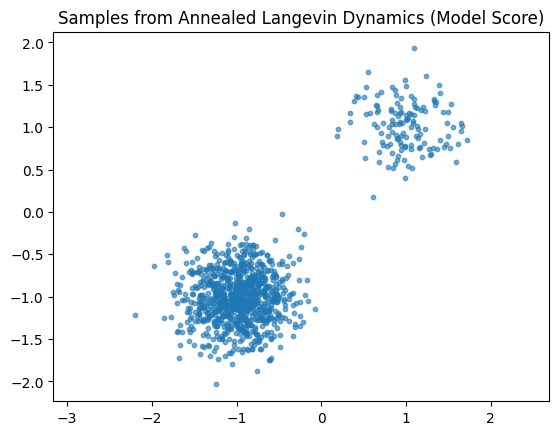

In [90]:
NOISE_SCALES = torch.logspace(torch.log10(torch.tensor(2.0)), torch.log10(torch.tensor(0.01)), 10)
LANGEVIN_STEP_SIZE = 1e-5
print(f'The noise being added to the data at each step is: {NOISE_SCALES} (geometric sequence)')

### YOUR CODE HERE ###
x_t = torch.randn(1000,2)
model.eval()

for sigma_t in NOISE_SCALES:
        step_size = LANGEVIN_STEP_SIZE * sigma_t**2 / NOISE_SCALES[-1]**2
        for _ in range(LANGEVIN_NUM_STEPS // 10):
            with torch.no_grad():
                score = model(x_t)
                noise = torch.randn_like(x_t)
                x_t = x_t + 0.5 * step_size * score + torch.sqrt(step_size) * noise
            
plt.scatter(x_t[:, 0], x_t[:, 1], s=10, alpha=0.6)
plt.title("Samples from Annealed Langevin Dynamics (Model Score)")
plt.axis("equal")
plt.show()


## Putting it all together!

In this section you will be using everything you learned to generate images from MNIST, provided to you in your virtual machines (and available in Pytorch). Ideas are based on the paper Generative Modeling by Estimating Gradients of the Data Distribution (2019). You can use the paper's official implementation as a guideline to the solution. It is recommended to go over the first tutorial before solving.

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1 - Denoising Score Matching

When the score function cannot be calculated directly (as above), we cannot simply use the MSE between the model output and the true score. Hence, we updated loss function, suiting it to our annealed noise schedule:

$$\ell_\text{denoise}(\theta; \sigma) := \frac{1}{2}\mathbb{E}_{x\sim p_\text{data}} \mathbb{E}_{\tilde{x}\sim q_\sigma(\cdot | x)} \left[ \Vert s_\theta(\tilde{x}, \sigma) - \log q_\sigma(\tilde{x}|x)\Vert^2 \right]$$
$$  L_\text{denoise}(\theta) = \frac{1}{L}\sum_{i=1}^L \lambda(\sigma_i)\ell_\text{denoise}(\theta; \sigma_i) \equiv \mathbb{E}_{i \sim \text{Uni}(1, L)} \left[ \sigma_i^2\ell_\text{denoise}(\theta; \sigma_i) \right] $$

Where the model is denoted as $s_\theta$ and $\sigma_i$ are the noise values.

In [92]:
def denoising_score_loss(model, x, noise_scales):
    """
    model: The score matching model.
    x: The input data [BATCH_SIZE, WIDTH, HEIGHT]
    noise_scales: The noise scales to use for denoising [NUM_NOISE_SCALES] (sigma_1, sigma_2, ..., sigma_L)
    """

    ### YOUR CODE HERE ###
    device = x.device
    batch_size = x.shape[0]
    

    noise_scale_idx = torch.randint(0, len(noise_scales), (batch_size,), device=device)
    sigma = noise_scales[noise_scale_idx].view(batch_size, 1, 1, 1)
    
    #perturb data
    noise = torch.randn_like(x) * sigma
    x_tilde = x + noise
    
    #target score
    target_score = -noise / (sigma ** 2)
    
    #predicted score
    pred_score = model(x_tilde, noise_scale_idx)
    
    #weighted MSE loss
    loss = ((pred_score - target_score) ** 2).mean(dim=(1, 2, 3))
    weighted_loss = (sigma.view(batch_size) ** 2) * loss
    
    return weighted_loss.mean()
    

### 2 - UNet

A great candidate for a model that receives an image and returns a value that is of the same dimensions as the image is a UNet. Below is a UNet architecture already implemented for you. In this section you don't need to implement / change anything, if you do please specify your changes below.

In [93]:
class CondInstanceNorm(nn.Module):
    def __init__(self, in_channels, n_noise_scale=10, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(n_noise_scale, in_channels))
        self.beta = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.alpha = nn.Parameter(torch.zeros(n_noise_scale, in_channels))
        self.eps = eps

    def forward(self, x, noise_scale_idx):
        bsz = x.shape[0]
        gamma = self.gamma[noise_scale_idx].view(bsz, -1, 1, 1)  # (bsz, in_channels, 1, 1)
        beta = self.beta[noise_scale_idx].view(bsz, -1, 1, 1)
        alpha = self.alpha[noise_scale_idx].view(bsz, -1, 1, 1)


        mu = x.mean(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        var = x.var(dim=(2, 3), keepdim=True)  # (batch_size, in_channels, 1, 1)
        sigma = torch.sqrt(var + self.eps)  # (batch_size, in_channels, 1, 1)
        

        x = (x - mu) / sigma  # (batch_size, in_channels, height, width)
        x = gamma * x + beta  # (batch_size, in_channels, height, width)

        m = mu.mean(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
        if mu.shape[1] == 1:
            s = torch.ones_like(mu)
        else:
            v = mu.var(dim=1, keepdim=True)  # (batch_size, 1, 1, 1)
            s = torch.sqrt(v + self.eps)  # (batch_size, 1, 1, 1)

        x = x + alpha * (mu - m) / s  # (batch_size, in_channels, height, width)
        return x


class ResidualConvUnit(nn.Module):
    def __init__(self, channels, norm=True, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.norm2 = CondInstanceNorm(channels, n_noise_scale) if norm else None
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)
        h = self.norm1(x, noise_scale_idx) if self.norm1 is not None else x
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx) if self.norm2 is not None else h
        h = self.act(h)
        h = self.conv2(h)
        
        return x + h
    
    

class StridedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()
    
    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)
        
        return h


class DilatedConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=2, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation, padding=dilation)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.norm1 = CondInstanceNorm(in_channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(out_channels, n_noise_scale)
        self.act = nn.ELU()

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.norm1(x, noise_scale_idx)
        h = self.act(h)
        h = self.conv1(h)

        h = self.norm2(h, noise_scale_idx)
        h = self.act(h)
        h = self.conv2(h)
        
        return h
    


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=2, downsample='stride', dilation=2, n_noise_scale=10):
        assert downsample in ['stride', 'dilation']
        super().__init__()
        self.downsample = downsample
        self.main = nn.ModuleList([])
        for _ in range(n_layers):
            self.main.append(ResidualConvUnit(in_channels, n_noise_scale=n_noise_scale))
        
        if downsample == 'stride':
            self.main.append(StridedConvUnit(in_channels, out_channels, n_noise_scale=n_noise_scale))
        elif downsample == 'dilation':
            self.main.append(DilatedConvUnit(in_channels, out_channels, dilation=dilation, n_noise_scale=n_noise_scale))

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        for layer in self.main:
            x = layer(x, noise_scale_idx)
        
        return x
    

class AdaptiveConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)
        self.conv3 = ResidualConvUnit(out_channels, n_noise_scale=n_noise_scale)

    def forward(self, x, noise_scale_idx):
        # x: (batch_size, in_channels, height, width)

        h = self.conv1(x)
        h = self.conv2(h, noise_scale_idx)
        h = self.conv3(h, noise_scale_idx)
        
        return h
    

class MultiResolutionFusion(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)

    def forward(self, x, y=None, noise_scale_idx=0):
        if y is None:
            return x
        else:
            h1 = self.norm1(x, noise_scale_idx)
            h1 = self.conv1(h1)

            h2 = self.norm2(y, noise_scale_idx)
            h2 = self.conv2(h2)

            return h1 + h2
        

class ResidualPoolingBlock(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.norm1 = CondInstanceNorm(channels, n_noise_scale)
        self.pool1 = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.norm2 = CondInstanceNorm(channels, n_noise_scale)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x, noise_scale_idx):
        h = self.norm1(x, noise_scale_idx)
        h = self.pool1(h)
        h = self.norm2(h, noise_scale_idx)
        h = self.conv1(h)

        return h


class ChainedResidualPool(nn.Module):
    def __init__(self, channels, n_noise_scale=10):
        super().__init__()
        self.act = nn.ELU()
        self.pool1 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)
        self.pool2 = ResidualPoolingBlock(channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        x = self.act(x)
        h = self.pool1(x, noise_scale_idx)
        x = x + h
        h = self.pool2(h, noise_scale_idx)
        x = x + h

        return x

class RefineNetBlock(nn.Module):
    def __init__(self, x1_in, x2_in, channels, n_noise_scale=10):
        super().__init__()
        self.adap_x1 = AdaptiveConvBlock(x1_in, channels, n_noise_scale=n_noise_scale)
        self.adap_x2 = AdaptiveConvBlock(x2_in, channels, n_noise_scale=n_noise_scale)

        self.fusion = MultiResolutionFusion(channels, n_noise_scale=n_noise_scale)
        self.pool = ChainedResidualPool(channels, n_noise_scale=n_noise_scale)

        self.out = ResidualConvUnit(channels, n_noise_scale=n_noise_scale)

    def forward(self, x1, x2=None, noise_scale_idx=0):
        h1 = self.adap_x1(x1, noise_scale_idx)
        h2 = self.adap_x2(x2, noise_scale_idx) if x2 is not None else None
        h = self.fusion(h1, h2, noise_scale_idx)
        h = self.pool(h, noise_scale_idx)
        h = self.out(h, noise_scale_idx)

        return h


class RefineNet(nn.Module):
    def __init__(self, in_channels, hidden_channels=(128, 256), n_noise_scale=10):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, hidden_channels[0], n_layers=2, downsample='stride')
        self.res2 = ResidualBlock(hidden_channels[0], hidden_channels[1], n_layers=2, downsample='dilation', dilation=2)
        ### YOU CAN ADD MORE RESIDUAL BLOCKS HERE ###
        
        self.refine1 = RefineNetBlock(x1_in=hidden_channels[-1], x2_in=hidden_channels[-1], channels=hidden_channels[-1], n_noise_scale=n_noise_scale)
        self.refine2 = RefineNetBlock(x1_in=hidden_channels[-2], x2_in=hidden_channels[-1], channels=hidden_channels[-2], n_noise_scale=n_noise_scale)
        ### EVERY RESIDUAL BLOCK SHOULD BE FOLLOWED BY A REFINE BLOCK ###

        self.up_norm = CondInstanceNorm(hidden_channels[-2], n_noise_scale)
        self.up_conv = nn.ConvTranspose2d(hidden_channels[-2], hidden_channels[-2], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.out = AdaptiveConvBlock(hidden_channels[-2], in_channels, n_noise_scale=n_noise_scale)


    def forward(self, x, noise_scale_idx):
        h1 = self.res1(x, noise_scale_idx)
        h2 = self.res2(h1, noise_scale_idx)

        h = self.refine1(h2, x2=None, noise_scale_idx=noise_scale_idx)  # As we know, U-Nets accept two inputs (previous layer and skip connection)
        h = self.refine2(h1, h, noise_scale_idx)

        h = self.up_norm(h, noise_scale_idx)
        h = self.up_conv(h)
        h = self.out(h, noise_scale_idx)

        return h
    
def q_sample(x, sigma, noise=None):
    # x: (B, C, H, W)
    # sigma: (B, )
    if noise is None:
        noise = torch.randn_like(x)
    while sigma.dim() < x.dim():
        sigma = sigma.unsqueeze(-1)
    return x + sigma * noise
    


### 3 - Training

Train a UNet according to the loss implemented above on MNIST. It is recommended to save checkpoints - the model's state dict in case of the machine turning off / crashing (the code should not need to run more than an hour anyways). All hyperparameters have been provided to you and should work in the case everything was implemented correctly. However, you are free to change any values for better performance.

In [94]:
N_EPOCHS = 30
BATCH_SIZE = 64
NOISE_SCALES = torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device)
LR = 1e-3  # Learning rate for the training - not the same as the step size of Langevin Dynamics
NUM_LANGEVIN_STEPS = 100  # Number of steps of Langevin Dynamics for each noise scale.
LANGEVIN_STEP_SIZE = 2e-5  # Base step size in Annealed Langevin Dynamics

In [95]:
# use MNIST as train set
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#preprocess to fit the dataset format to kaggles notebook
class MNISTFromCSV(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.labels = self.data['label'].values.astype('int64')
        self.images = self.data.drop('label', axis=1).values.reshape(-1, 28, 28).astype('float32') / 255.0
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).unsqueeze(0)  # [1, 28, 28]
        label = torch.tensor(self.labels[idx])
        return image, label
        
csv_path = "/kaggle/input/digit-recognizer/train.csv"
trainset = MNISTFromCSV(csv_path)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)


In [96]:
### YOUR CODE HERE ###
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # or CosineAnnealingLR
from tqdm import tqdm

def set_seed(seed=268):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(2001)

torch.cuda.empty_cache()
model = RefineNet(in_channels=1, hidden_channels=(128, 256), n_noise_scale=len(NOISE_SCALES)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min',              
    factor=0.5,              
    patience=3,              
    verbose=True,            
    min_lr=1e-6              
)

checkpoint_path = "./score_model_checkpoint.pth"

#keep training if checkpoint exists
try:
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    
    if "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    print("Starting training from scratch")
    start_epoch = 0
    
for epoch in range(start_epoch, N_EPOCHS):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (images, _) in enumerate(tqdm(trainloader)):
        images = images.to(device)
        optimizer.zero_grad()
        loss = denoising_score_loss(model, images, NOISE_SCALES)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{N_EPOCHS}], Loss: {avg_loss:.5f}")
    
    scheduler.step(avg_loss)
    
    #save checkpoint every epoch
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "loss": avg_loss
    }, checkpoint_path)
    
    if epoch + 1 == N_EPOCHS:
        from IPython.display import FileLink
        display(FileLink(checkpoint_path))

Resuming training from epoch 30


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_31/2937457233.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of t

### 4 - Sampling

Generate images using Annealed Langevin Dynamics with the model you have trained above. Visualize the process, you can use the function below or any other method. The images do not need to be perfect but it must be clear that they are handwritten digits with a black background. Example imperfect output:

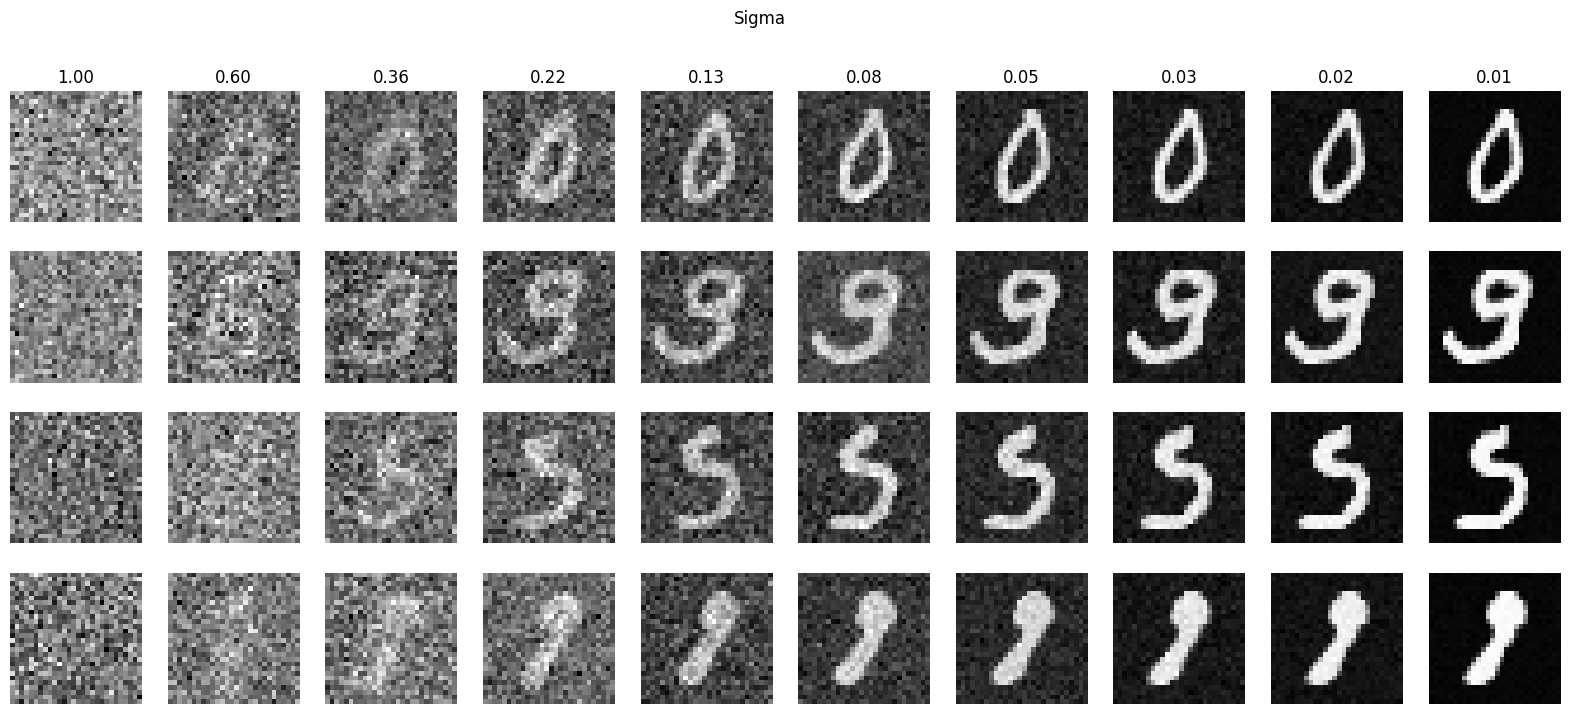

In [97]:
def sample_refinenet(model, shape, noise_scales, device, n_steps, eps, visualize_dynamics_file):
    """Generates images using the model that was trained with score matching.
    noise_scales: Sigmas for annealed LD.
    n_steps: Number of steps for each sigma.
    eps: Step size in LD.
    visualize_dynamics_file: Saves the dynamics (the denoising process of the Langevin dynamics) in a file.
    """
    model.eval()
    with torch.no_grad():
        fig, ax = plt.subplots(shape[0], len(noise_scales), figsize=(len(noise_scales)*2, shape[0]*2))
        fig.suptitle('Sigma')

        ### YOUR CODE HERE ###
        x = torch.randn(shape).to(device) 
        samples_history = []
        samples_history.append(x.detach().cpu())

        for i, sigma in enumerate(noise_scales):
            if shape[0] == 1:
                ax[i].set_title(f'{sigma:.4f}')
            else:
                for row in range(shape[0]):
                    ax[row, i].set_title(f'{sigma:.4f}')
            step_size = eps * (sigma / noise_scales[-1]) ** 2

            #run Langevin dynamics for n_steps at this noise level
            for t in range(n_steps):
                #generate random noise
                z = torch.randn_like(x) * torch.sqrt(torch.tensor(2.0).to(device))
                
                #score estimate from model
                noise_scale_idx = torch.full((shape[0],), i, device=device)
                score = model(x, noise_scale_idx)
                
                #update role
                x = x + step_size * score + torch.sqrt(torch.tensor(step_size).to(device)) * z
                
                # Save intermediate results at regular intervals for visualization
                if t % (n_steps // 4) == 0 or t == n_steps - 1:
                    samples_history.append(x.detach().cpu())
            
            # Display current samples after this noise scale
            for j in range(shape[0]):
                img = x[j, 0].detach().cpu().numpy()
                if shape[0] == 1:
                    ax[i].imshow(img, cmap='gray')
                    ax[i].axis('off')
                else:
                    ax[j, i].imshow(img, cmap='gray')
                    ax[j, i].axis('off')
        
        # Save the visualization of the denoising process
        plt.tight_layout()
        plt.savefig(visualize_dynamics_file)
        plt.close()
        
        # Create and save a more detailed denoising process visualization
        n_snapshots = len(samples_history)
        fig2, axes = plt.subplots(shape[0], n_snapshots, 
                                 figsize=(n_snapshots*2, shape[0]*2))
        fig2.suptitle('Denoising Process')
        
        for i, samples in enumerate(samples_history):
            for j in range(shape[0]):
                img = samples[j, 0].numpy()
                if shape[0] == 1:
                    axes[i].imshow(img, cmap='gray')
                    axes[i].axis('off')
                else:
                    axes[j, i].imshow(img, cmap='gray')
                    axes[j, i].axis('off')
        
        # Save the detailed denoising process
        detailed_file = visualize_dynamics_file.replace('.png', '_detailed.png')
        plt.tight_layout()
        plt.savefig(detailed_file)
        plt.close()
        
        return x  # Return the final generated samples

/tmp/ipykernel_31/886862744.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + step_size * score + torch.sqrt(torch.tensor(step_size).to(device)) * z


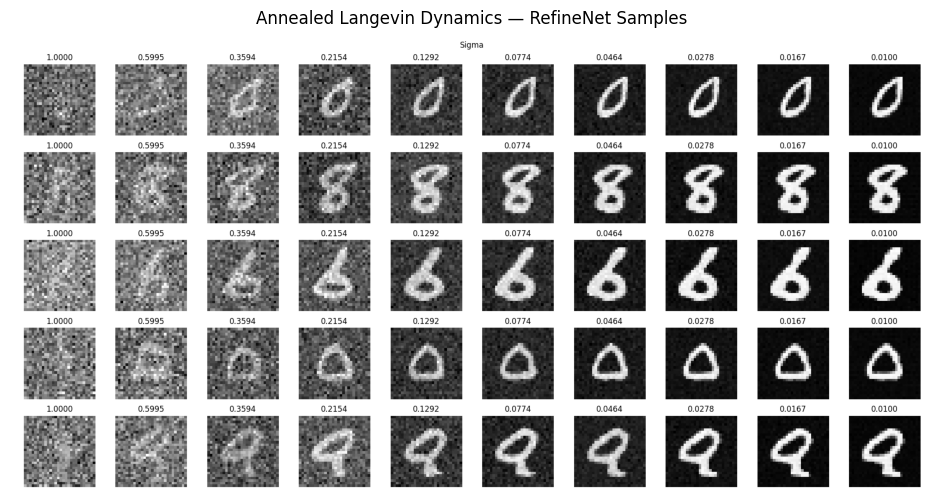

In [110]:
# Sample from the RefineNet model
from PIL import Image
import matplotlib.pyplot as plt
import torch
import random
import numpy as np

# --- Set seed for reproducibility ---
def set_seed(seed=268):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(268)


BATCH_SIZE = 5
IMG_SHAPE = (BATCH_SIZE, 1, 28, 28)

NOISE_SCALES = torch.logspace(torch.log10(torch.tensor(1.0)), torch.log10(torch.tensor(0.01)), 10).to(device)
NUM_LANGEVIN_STEPS = 100
LANGEVIN_STEP_SIZE = 2e-5

#Output
output_file = "langevin_digits.png"

sample_refinenet(
    model=model,
    shape=IMG_SHAPE,
    noise_scales=NOISE_SCALES,
    device=device,
    n_steps=NUM_LANGEVIN_STEPS,
    eps=LANGEVIN_STEP_SIZE,
    visualize_dynamics_file=output_file
)


# Load and display the image saved in the previous step
img = Image.open("langevin_digits.png")
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Annealed Langevin Dynamics — RefineNet Samples")
plt.show()
